# Assignment 4

Deadline: 30.04.2025 12:00 CET

<Add your name, student-id and emal address>

## Prerequisites: Library imports, data load and initialization of the backtest service

In [1]:
# Standard library imports
import os
import sys
import copy
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course', 'src')
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [2]:
# Load data
path_to_data = '/Users/sarah/qpmwp-course/data/'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='../data/')  # <change this if necessary>

In [3]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [4]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [ ]:
# Thought process: 1. solve mean-variance for 10 different values of risk aversion parameter (use this parameter as a control param for balancing risk and return) 
#                  2. find the weights that give the highest sharpe ratio
class MaxSharpe(Optimization):
    def __init__(self, constraints=None, covariance=None, expected_return=None, **kwargs):
        super().__init__(constraints=constraints, **kwargs)
        self.covariance = covariance or Covariance()
        self.expected_return = expected_return or ExpectedReturn()
        self.sharpe_ratio = None

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self._optimization_data = optimization_data
        return None

    def solve(self) -> None:
        # Initialize
        gamma = 1.0  # Starting risk aversion
        tol = 1e-6
        max_iter = 10
        λ = self.params.get('turnover_penalty', 0.0)
        ids = self.constraints.ids
        prev_weights = np.zeros(len(ids))
        
        # Get data
        X = self._optimization_data['return_series']
        mu = self.expected_return.estimate(X, inplace=False)
        Sigma = self.covariance.estimate(X, inplace=False)
        
        # Align with constraints
        mu = pd.Series(mu, index=X.columns).reindex(ids).to_numpy()
        Sigma = pd.DataFrame(Sigma, index=X.columns, columns=X.columns).reindex(index=ids, columns=ids).to_numpy()

        for iter in range(max_iter):
            # Build objective
            q = -mu + λ * np.sign(prev_weights)
            P = 2 * gamma * Sigma
            
            # Solve
            mv = MeanVariance(
                constraints=self.constraints,
                covariance=self.covariance,
                expected_return=self.expected_return,
                risk_aversion=gamma,  # Still needed for other calculations
                **self.params
            )
            mv.objective = Objective(q=q, P=P)
            mv.solve()
            
            # Get weights
            w = np.array([mv.results['weights'][id] for id in ids])
            
            # Calculate metrics
            port_ret = w @ mu
            port_var = w @ Sigma @ w
            
            # Check convergence
            if port_var < 1e-8:
                break
                
            gamma_new = port_ret / port_var
            
            # Damped update (70% old, 30% new)
            gamma = 0.7*gamma + 0.3*gamma_new
            
            if abs(gamma_new - gamma) < tol:
                print(f"Converged after {iter+1} iterations")
                break
                
            prev_weights = w
            
            #print(f"Iter {iter+1}: γ={gamma:.4f}, Return={port_ret:.4f}, Vol={np.sqrt(port_var):.4f}")

        # Store results
        self.results = {
            'weights': dict(zip(ids, w)),
            'sharpe_ratio': port_ret / np.sqrt(port_var),
            'risk_aversion': gamma,
            'status': True
        }
        self.sharpe_ratio = port_ret / np.sqrt(port_var)

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

In [8]:
# bs.optimization = MaxSharpe(
#     covariance=Covariance(method='pearson'),
#     expected_return=ExpectedReturn(method='geometric'),
#     solver_name='cvxopt',  # <change this to your preferred solver>
#     #<add any other parameters you need, e.g., number of iterations, tolerance, etc.>
# )
# bs.prepare_rebalancing('2015-01-02')
# bs.optimization.set_objective(bs.optimization_data)
# bs.optimization.solve()
# bs.optimization.results

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [ ]:
def grid_search_turnover():
    penalties = [0.01, 0.05, 0.1, 0.5]
    results = []
    
    for penalty in penalties:
        bs.optimization = MaxSharpe(
            covariance=Covariance(method='pearson'),
            expected_return=ExpectedReturn(method='geometric'),
            solver_name='cvxopt',    # <change this to your preferred solver>
            turnover_penalty=penalty,   # <change this>
)
        bt = Backtest()
        bt.run(bs=bs)
        annual_to = bt.strategy.turnover(bs.data.get_return_series()).mean() * 4
        results.append((penalty, annual_to))
        print(f"Penalty: {penalty:.4f} → Annual TO: {annual_to:.2%}")
    
    # 找到最接近100%的值
    best_penalty = min(results, key=lambda x: abs(x[1] - 1.0))
    return best_penalty

In [ ]:
grid_search_turnover()

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

(0.01, np.float64(0.4133827927277501))

In [53]:
# Update the backtest service with a MaxSharpe optimization object
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',    # <change this to your preferred solver>
    turnover_penalty=0.00035,   # <change this>
)

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs = bs)

Rebalancing date: 2015-01-02
Iter 1: γ=6.1181, Return=0.0010, Vol=0.0075
Iter 2: γ=10.6913, Return=0.0010, Vol=0.0068
Iter 3: γ=14.7149, Return=0.0009, Vol=0.0062
Iter 4: γ=17.6529, Return=0.0009, Vol=0.0061
Iter 5: γ=19.8251, Return=0.0009, Vol=0.0059
Iter 6: γ=21.3844, Return=0.0009, Vol=0.0059
Iter 7: γ=22.4887, Return=0.0009, Vol=0.0059
Iter 8: γ=23.2702, Return=0.0009, Vol=0.0058
Iter 9: γ=23.8219, Return=0.0008, Vol=0.0058
Iter 10: γ=24.2098, Return=0.0008, Vol=0.0058
Rebalancing date: 2015-04-01
Iter 1: γ=6.3009, Return=0.0010, Vol=0.0073
Iter 2: γ=10.3736, Return=0.0010, Vol=0.0069
Iter 3: γ=13.2478, Return=0.0009, Vol=0.0069
Iter 4: γ=15.2783, Return=0.0009, Vol=0.0068
Iter 5: γ=16.7450, Return=0.0009, Vol=0.0067
Iter 6: γ=17.8298, Return=0.0009, Vol=0.0066
Iter 7: γ=18.6013, Return=0.0009, Vol=0.0066
Iter 8: γ=19.1401, Return=0.0009, Vol=0.0066
Iter 9: γ=19.5164, Return=0.0009, Vol=0.0066
Iter 10: γ=19.7789, Return=0.0009, Vol=0.0066
Rebalancing date: 2015-06-29
Iter 1: γ=5.9

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


/Users/sarah/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
/Users/sarah/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Axes: title={'center': 'Cumulative Performance'}>

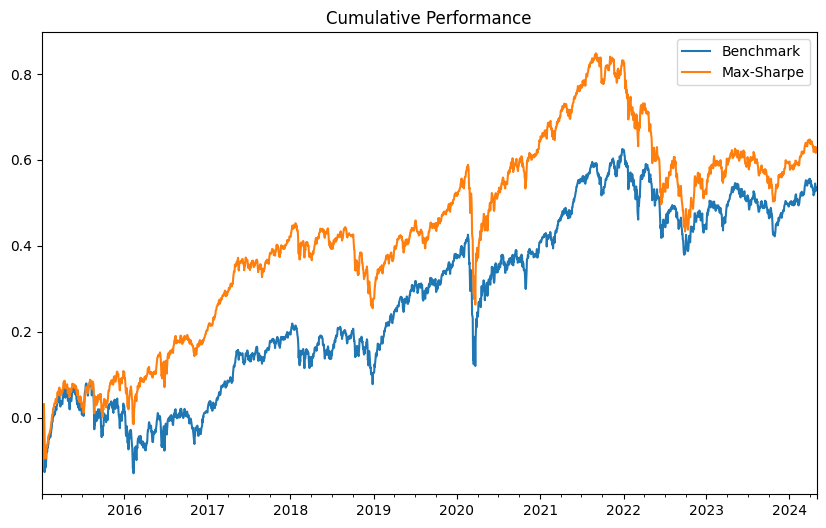

In [54]:
import empyrical as ep

return_series = bs.data.get_return_series()  # Get the underlying asset returns
bm_series = bs.data.bm_series  # Get benchmark returns

fixed_cost = 0.01  # 1%
variable_cost = 0.003  # 0.3%

sim_maxsharpe = bt_ms.strategy.simulate(
    return_series=return_series,
    fc=fixed_cost,
    vc=variable_cost
)

sim = pd.concat({
    'Benchmark': bm_series,
    'MaxSharpe': sim_maxsharpe
}, axis=1).dropna()
sim.columns = ['Benchmark', 'Max-Sharpe']

# Plot the cumulative performance
np.log((1 + sim)).cumsum().plot(title='Cumulative Performance', figsize = (10, 6))


annual_turnover is 0.6103091687783965


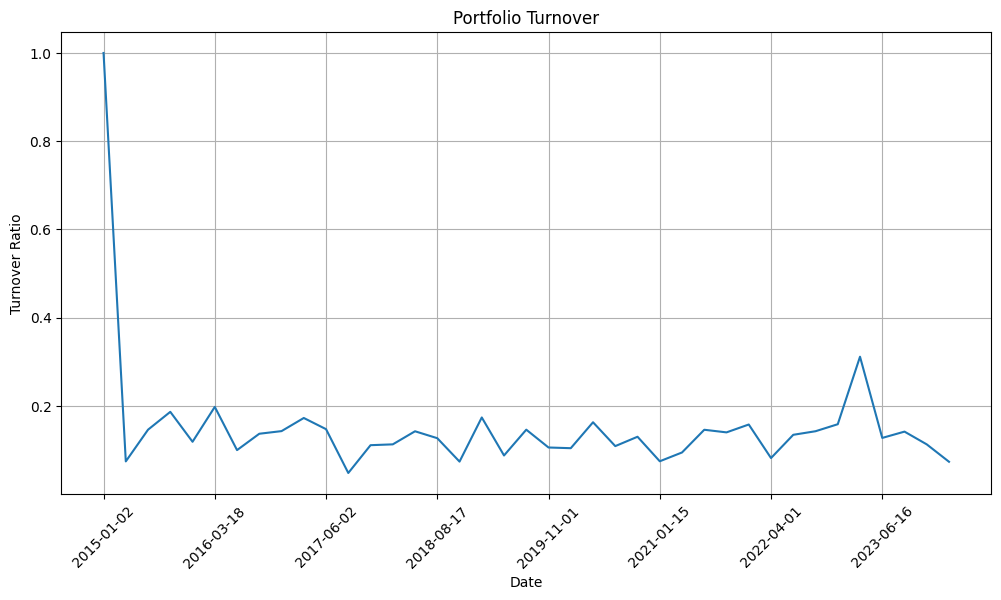

In [55]:
# Turnover Part
turnover_series = bt_ms.strategy.turnover(
    return_series=bs.data.get_return_series(),
    rescale=True  
)

turnover_series.plot(
    title='Portfolio Turnover',
    xlabel='Date',
    ylabel='Turnover Ratio',
    grid=True,
    figsize=(12, 6),
    rot = 45
)

annual_turnover = turnover_series.mean() * 4
print(f'annual_turnover is {annual_turnover}')

In [56]:
annual_turnover = turnover_series.mean() * 4
annual_turnover

np.float64(0.6103091687783965)

In [57]:
# Compute individual performance metrics for each simulated strategy using empyrical
annual_return = {}
cumulative_returns = {}
annual_volatility = {}
sharpe_ratio = {}
max_drawdown = {}
tracking_error = {}
for column in sim.columns:
    print(f'Performance metrics for {column}')
    annual_return[column] = ep.annual_return(sim[column])
    cumulative_returns[column] = ep.cum_returns(sim[column]).tail(1).values[0]
    annual_volatility[column] = ep.annual_volatility(sim[column])
    sharpe_ratio[column] = ep.sharpe_ratio(sim[column])
    max_drawdown[column] = ep.max_drawdown(sim[column])
    tracking_error[column] = ep.annual_volatility(sim[column] - sim['Benchmark'])


annual_returns = pd.DataFrame(annual_return, index=['Annual Return'])
cumret = pd.DataFrame(cumulative_returns, index=['Cumulative Return'])
annual_volatility = pd.DataFrame(annual_volatility, index=['Annual Volatility'])
sharpe  = pd.DataFrame(sharpe_ratio, index=['Sharpe Ratio'])
mdd = pd.DataFrame(max_drawdown, index=['Max Drawdown'])
tracking_error = pd.DataFrame(tracking_error, index=['Tracking Error'])
pd.concat([annual_returns, cumret, annual_volatility, sharpe, mdd, tracking_error])

Performance metrics for Benchmark
Performance metrics for Max-Sharpe


,Benchmark,Max-Sharpe
Annual Return,0.056593,0.066751
Cumulative Return,0.701100,0.865657
Annual Volatility,0.145690,0.136891
Sharpe Ratio,0.451148,0.540859
Max Drawdown,-0.263289,-0.339514
Tracking Error,0.000000,0.067348


In [58]:
dates = pd.to_datetime(turnover_series.index)
n_years = (dates[-1] - dates[0]).days / 365.25
rebalancings_per_year = len(dates) / n_years
rebalancings_per_year

4.249627088305489